In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random as random
%matplotlib inline
from casadi import *

In [2]:
#Ce fichier charge et trace 3 trajectoires humaines différentes avec différentes positions de départ et orientations :
#- human_traj_1 commence théoriquement à partir de (-4,-0,9,-pi/2)
#- human_traj_2 commence théoriquement à partir de (-1.5,1.2,0)
#- human_traj_3 commence théoriquement à partir de (-4,-3.4,pi/2)
# La position de but est toujours (0,0,pi/2).

#Les fichiers sont organisés comme suit :
#- de 0 à 5 : trajectoire moyenne (0->x,1->y,2->vx,3->vy,4->theta local,5->theta global)
#- de 6 à 11 : trajectoire du suject 1
#- de 12 à 17 : trajectoire du suject 2
#- de 18 à 23 : trajectoire du suject 3
#- de 24 à 29 : trajectoire du suject 4
#- de 30 à 35 : trajectoire du suject 5
#- de 36 à 41 : trajectoire du suject 6
#- de 42 à 47 : trajectoire du suject 7
#- de 48 à 53 : trajectoire du suject 8
#- de 54 à 59 : trajectoire du suject 9
#- de 60 à la fin : trajectoire du suject 10



In [3]:
def plot_traj(name,ind):
    plt.subplot(3,3,ind*3+1)
    m = np.loadtxt(name)
    plt.plot(m[0],m[1],color='green',label='mean traj')
    plt.plot(m[6],m[7],color='green',linewidth=0.75,alpha = 0.5,label='individual traj')
    plt.plot(m[12],m[13],color='green',linewidth=0.75,alpha = 0.5)
    plt.plot(m[18],m[19],color='green',linewidth=0.75,alpha = 0.5)
    plt.plot(m[24],m[25],color='green',linewidth=0.75,alpha = 0.5)
    plt.plot(m[30],m[31],color='green',linewidth=0.75,alpha = 0.5)
    plt.plot(m[36],m[37],color='green',linewidth=0.75,alpha = 0.5)
    plt.plot(m[42],m[43],color='green',linewidth=0.75,alpha = 0.5)
    plt.plot(m[48],m[49],color='green',linewidth=0.75,alpha = 0.5)
    plt.plot(m[54],m[55],color='green',linewidth=0.75,alpha = 0.5)
    plt.plot(m[60],m[61],color='green',linewidth=0.75,alpha = 0.5)
    plt.ylabel("y (m)")
    plt.xlabel("x (m)")
    plt.legend()

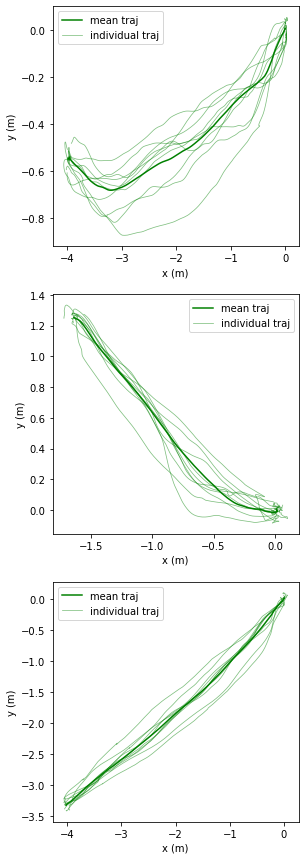

In [4]:
end = 100
time = np.arange(0,end,0.2)
list_name = ["human_traj_1.dat","human_traj_2.dat","human_traj_3.dat"]


plt.figure(figsize = (15,15))
for i in range(len(list_name)):
    plot_traj(list_name[i], i)

plt.show()

# Modèle Unicycle

### DOC

In [5]:
n = 500
taux = 1/n

In [6]:
x=SX.sym('x',n)
f= Function('f',[x],[x[1:]])

In [7]:
def Unicycle_DOC (f, Xi , Xf , c1 , c2) :
    x1i = Xi[0] 
    x2i = Xi[1]
    x3i = Xi[2]
    
    x1f = Xf[0] 
    x2f = Xf[1]
    x3f = Xf[2]
    
    opti = casadi.Opti()   # cette fonction nous permet de trouver la solution de problème

    u1 = opti.variable(n)
    u2 = opti.variable(n)
    x1 = opti.variable(n)
    x2 = opti.variable(n)
    x3 = opti.variable(n)

    opti.minimize(   (taux/2)*(c1*dot(u1,u1)+c2*dot(u2,u2))   )    # ma fonction objetion

    # mes fonctions de contrainte d'égalité:

    ## pour les condition initial
    opti.subject_to( x1[0]==x1i)        
    opti.subject_to( x2[0]==x2i)
    opti.subject_to( x3[0]==x3i)

    ## pour les contraintes d'égaliter
    opti.subject_to( x1[:n-1]+taux*u1[:n-1]*cos(x3[:n-1])==f(x1) )
    opti.subject_to( x2[:n-1]+taux*u1[:n-1]*sin(x3[:n-1])==f(x2) )
    opti.subject_to( x3[:n-1]+taux*u2[:n-1] ==f(x3))

    ## pour les conditions finales
    opti.subject_to( x1[-1]==x1f)
    opti.subject_to( x2[-1]==x2f)
    opti.subject_to( x3[-1]==x3f)


    opti.solver('ipopt')      # suivant la méthode de KKT


    sol = opti.solve()
    
    X1 = sol.value(x1)
    X2 = sol.value(x2)
    X3 = sol.value(x3)
    
    U1 = sol.value(u1)
    U2 = sol.value(u2)
    
    return X1,X2,X3,U1,U2

### IOC 

In [8]:
x1i = SX.sym('x1i',1)                   
x2i = SX.sym('x2i',1)                
x3i = SX.sym('x3i',1)


x1f = SX.sym('x1f',1)
x2f = SX.sym('x2f',1)
x3f = SX.sym('x3f',1)


c1 = SX.sym('c1',1)
c2 = SX.sym('c2',1)

u1=SX.sym('u1',n)  
u1_prime = SX.sym('u1_prime', n+1)
u1_prime[0] = 0
u1_prime[n] = 0
u1_prime[1:n] =u1[0:n-1]

u2=SX.sym('u2',n)  
u2_prime = SX.sym('u2_prime', n+1)
u2_prime[0] = 0
u2_prime[n] = 0
u2_prime[1:n] =u2[0:n-1]

x1=SX.sym('x1',n)
x1_prime = SX.sym('x1_prime', n+1)
x1_prime[0] = x1[0]
x1_prime[1:] =x1


x2=SX.sym('x2',n)
x2_prime = SX.sym('x1_prime', n+1)
x2_prime[0] = x2[0]
x2_prime[1:] =x2

x3=SX.sym('x3',n)
x3_prime = SX.sym('x1_prime', n+1)
x3_prime[0] = x3[0]
x3_prime[1:] =x3

Lambda = SX.sym('Lambda',n+1, 3)

In [9]:
p1=vertcat(x1i,x1_prime[2:],x1f)   # Je définis un nouveau vecteur suivant x1 en prenant les n-1 dernières valeurs 
                               #  et la nième valeur vaut x1f
g= Function('g',[x1, x1i, x1f],[p1])

In [10]:
Y1_U = (x1_prime+taux*u1_prime*cos(x3_prime) - g(x1, x1i,x1f))
Y2_U = (x2_prime+taux*u1_prime*sin(x3_prime) - g(x2, x2i,x2f)) 
Y3_U = (x3_prime+taux*u2_prime - g(x3, x3i,x3f))
Y_U = SX.sym('Y',n+1 , 3)        ## notre contrainte

for i in range (n+1):
    Y_U[i,0]= Y1_U[i]
    Y_U[i,1]= Y2_U[i]
    Y_U[i,2]= Y3_U[i]       

In [11]:
## notre terme qui est relié a la contrainte.
G_lambda = 0

for i in range (n+1):
    G_lambda += dot(Y_U[i,:], Lambda[i,:])
    
G_U = Function('G_U', [x1,x2,x3, Lambda], [G_lambda])


## notre fonction F 
F_val_U = (taux/2)*(c1*dot(u1,u1)+c2*dot(u2,u2))


## le Lagrangien 
L_val_U = F_val_U + G_lambda

In [12]:
grad_L_U = SX.zeros(5, n)
for i in range (n):
    grad_L_U[0,i]= jacobian(L_val_U, u1[i])
    grad_L_U[1,i]= jacobian(L_val_U, u2[i])
    grad_L_U[2,i]= jacobian(L_val_U, x1[i])
    grad_L_U[3,i]= jacobian(L_val_U, x2[i])
    grad_L_U[4,i]= jacobian(L_val_U, x3[i])
    
    
R_U = Function ('R_U', [u1,u2,x1,x2,x3, Lambda, c1, c2, x1i,x2i,x3i, x1f,x2f,x3f ], [(dot(grad_L_U,grad_L_U))])

In [13]:
def Unicycle_IOC (R_U, U1,U2,X1,X2,X3,Xi,Xf) :
    x1i = Xi[0] 
    x2i = Xi[1]
    x3i = Xi[2]
    
    x1f = Xf[0] 
    x2f = Xf[1]
    x3f = Xf[2]
    
    opti = casadi.Opti()   # cette fonction nous permet de trouver la solution de problème

    c1    = opti.variable()
    c2    = opti.variable()

    Lambda = opti.variable(n+1,3)
    
    opti.minimize( R_U(U1,U2,X1,X2,X3, Lambda, c1, c2 , x1i,x2i,x3i, x1f,x2f,x3f ))  

    opti.subject_to( 0 <= c1)
    opti.subject_to( 0 <= c2 )
    opti.subject_to(  c1 + c2 == 1)

    opti.solver('ipopt')    

    sol = opti.solve()
    
    return sol.value(c1), sol.value(c2) , sol.value(Lambda)

# Modèle Katja Mombaur

## DOC

In [16]:
n = 500
T = 5
taux1 = T/n

In [17]:
x = SX.sym('x', n )
p =vertcat(x[1:],0)
h = Function ('h',[x],[p])

In [18]:
def Katja_Mombaur_DOC (f,h, Xi, Xf, alpha1, alpha2, alpha3):
    xi = Xi[0] 
    yi = Xi[1]
    thetai = Xi[2]
    
    xf = Xf[0] 
    yf = Xf[1]
    thetaf = Xf[2]
    
    opti = casadi.Opti()   # cette fonction nous permet de trouver la solution de problème

    ## les positions
    x = opti.variable(n)
    y = opti.variable(n)
    theta = opti.variable(n)

    ## les vitesses 
    v1 = opti.variable(n)        ## vitesse latérale
    v2 = opti.variable(n)        ## vitesse orthogonal
    w = opti.variable(n)         ## vitesse angulaire
    
    opti.minimize(  taux1*(alpha1 * dot((h(v1)-v1)/taux ,(h(v1)-v1)/taux ) + alpha2 * dot((h(w)-w)/taux ,(h(w)-w)/taux ) + alpha3 * dot((h(v2)-v2)/taux ,(h(v2)-v2)/taux ))   )    # ma fonction objetion

    # mes fonctions de contrainte d'égalité:

    ## pour les condition initial
    opti.subject_to( x[0] == xi)        
    opti.subject_to( y[0] == yi)
    opti.subject_to( theta[0] == thetai)

    ## pour les contraintes d'égaliter
    opti.subject_to( f(x) == x[:n-1]+taux1*(cos(theta[:n-1])*v1[:n-1] - sin(theta[:n-1])*v2[:n-1]) )
    opti.subject_to( f(y) == y[:n-1]+taux1*(sin(theta[:n-1])*v1[:n-1] + cos(theta[:n-1])*v2[:n-1]) )
    opti.subject_to( f(theta) == theta[:n-1] + taux1*w[:n-1] )


    ## pour les conditions finales
    opti.subject_to( x[-1]==xf)
    opti.subject_to( y[-1]==yf)
    opti.subject_to( theta[-1]==thetaf)


    opti.solver('ipopt')      # suivant la méthode de KKT


    sol = opti.solve()
    
    
    X = sol.value(x)
    Y = sol.value(y)
    THETA = sol.value(theta)
    
    V1 = sol.value(v1)
    V2 = sol.value(v2)
    W = sol.value(w)
    
    return X,Y,THETA, V1,V2,W

## IOC

In [19]:
xi = SX.sym('xi',1)                   
yi = SX.sym('yi',1)                
thetai = SX.sym('thetai',1)


xf = SX.sym('xf',1)
yf = SX.sym('yf',1)
thetaf = SX.sym('thetaf',1)

alpha1 = SX.sym('alpha1',1)
alpha2 = SX.sym('alpha2',1)
alpha3 = SX.sym('alpha3',1)

## Position
x=SX.sym('x',n)
x_prime = SX.sym('x_prime', n+1)
x_prime[0] = x[0]
x_prime[1:] =x


y=SX.sym('y',n)
y_prime = SX.sym('y_prime', n+1)
y_prime[0] = y[0]
y_prime[1:] =y

theta=SX.sym('theta',n)
theta_prime = SX.sym('theta_prime', n+1)
theta_prime[0] = theta[0]
theta_prime[1:] =theta


## Vitesse
v1=SX.sym('v1',n)  
v1_prime = SX.sym('v1_prime', n+1)
v1_prime[0] = 0
v1_prime[n] = 0
v1_prime[1:n] =v1[0:n-1]

v2=SX.sym('v2',n)  
v2_prime = SX.sym('v2_prime', n+1)
v2_prime[0] = 0
v2_prime[n] = 0
v2_prime[1:n] =v2[0:n-1]


w=SX.sym('w',n)  
w_prime = SX.sym('w_prime', n+1)
w_prime[0] = 0
w_prime[n] = 0
w_prime[1:n] =w[0:n-1]

Lambda = SX.sym('Lambda',n+1, 3)

In [20]:
Y1_K = (x_prime+taux1*(v1_prime*cos(theta_prime) - v2_prime*sin(theta_prime)) - g(x, xi,xf))
Y2_K = (y_prime+taux1*(v1_prime*sin(theta_prime) + v2_prime*cos(theta_prime)) - g(y, yi,yf)) 
Y3_K = (theta_prime+taux1*w_prime - g(theta, thetai,thetaf))
Y_K = SX.sym('Y',n+1 , 3)        ## notre contrainte

for i in range (n+1):
    Y_K[i,0]= Y1_K[i]
    Y_K[i,1]= Y2_K[i]
    Y_K[i,2]= Y3_K[i]       
    
## notre terme qui est relié a la contrainte.
G_lambda = 0

for i in range (n+1):
    G_lambda += dot(Y_K[i,:], Lambda[i,:])

In [21]:
p =vertcat(v1[1:],0)
K = Function ('K',[v1],[p])

U1 = (K(v1)-v1)/taux1 

U2 = (K(w)-w)/taux1 

U3 = (K(v2)-v2)/taux1 

In [22]:
F_val_K =  taux1*(  alpha1 * dot(U1,U1) + alpha2 * dot(U2,U2) + alpha3 * dot(U3,U3))

## le Lagrangien 
L_val_K = F_val_K + G_lambda

In [23]:
grad_L_K = SX.zeros(6, n)
for i in range (n):
    grad_L_K[0,i]= jacobian(L_val_K, v1[i])
    grad_L_K[1,i]= jacobian(L_val_K, w[i])
    grad_L_K[2,i]= jacobian(L_val_K, v2[i])
    grad_L_K[3,i]= jacobian(L_val_K, x[i])
    grad_L_K[4,i]= jacobian(L_val_K, y[i])
    grad_L_K[5,i]= jacobian(L_val_K, theta[i])
    
    
R_K = Function ('R_K', [v1,w,v2,x,y,theta, Lambda, alpha1, alpha2, alpha3 ,xi,yi,thetai, xf,yf,thetaf  ], [dot(grad_L_K,grad_L_K)])

In [24]:
def Katja_Mombaur_IOC (R_K, V1,V2,W,X,Y,THETA,Xi,Xf) :
    xi = Xi[0] 
    yi = Xi[1]
    thetai = Xi[2]
    
    xf = Xf[0] 
    yf = Xf[1]
    thetaf = Xf[2]
    
    opti = casadi.Opti()   # cette fonction nous permet de trouver la solution de problème

    alpha1 = opti.variable()
    alpha2 = opti.variable()
    alpha3 = opti.variable()
    Lambda = opti.variable(n+1,3)
    
    opti.minimize( R_K(V1,W,V2,X,Y,THETA, Lambda, alpha1, alpha2, alpha3, xi,yi,thetai, xf,yf,thetaf  )) 

    opti.subject_to( 0 <= alpha1)

    opti.subject_to( 0 <= alpha2 )

    opti.subject_to( 0 <= alpha3 )

    opti.subject_to(  alpha1 + alpha2 + alpha3 == 1)



    opti.solver('ipopt')    

    sol = opti.solve()
    
    Alpha1 = sol.value (alpha1)
    Alpha2 = sol.value (alpha2)   
    Alpha3 = sol.value (alpha3)
    
    return Alpha1, Alpha2, Alpha3 , sol.value(Lambda)

# Première trajectoire

In [115]:
T1 = np.loadtxt("human_traj_1.dat")

In [116]:
X1 = T1[0]
X2 = T1[1]
X3 = T1[5]

U1 = T1[2]*cos(T1[4])
U2 = (K(T1[5])-T1[5])/taux


Xi = [X1[0],X2[0],X3[0]]
Xf = [X1[-1],X2[-1],X3[-1]]

x1i = Xi[0]
x2i = Xi[0]
x3i = Xi[0]

x1f = Xf[-1]
x2f = Xf[-1]
x3f = Xf[-1]


X = T1[0]
Y = T1[1]
THETA = T1[5]

V1 = T1[2]
V2 = T1[3]
W  = (K(T1[5])-T1[5])/taux

In [117]:
## Puydupin-Jamin

c1, c2, Lambda = Unicycle_IOC (R_U, U1,U2,X1,X2,X3,Xi,Xf)

Residue_Unicycle_IOC = R_U(U1,U2,X1,X2,X3, Lambda, c1, c2 , x1i,x2i,x3i, x1f,x2f,x3f ) 

X1_S1 ,X2_S1,X3_S1,U1_S1,U2_S1  = Unicycle_DOC (f, Xi , Xf , c1 , c2) 

Residue_Unicycle_DOC = R_U(U1_S1,U2_S1,X1_S1,X2_S1,X3_S1, Lambda, c1, c2 , x1i,x2i,x3i, x1f,x2f,x3f ) 


## Katja_Mombaur

alpha1, alpha2, alpha3, Lambda = Katja_Mombaur_IOC (R_K, V1,V2,W,X,Y,THETA,Xi,Xf)

Residue_Mombaur_IOC  = R_K(V1,W,V2,X,Y,THETA, Lambda, alpha1, alpha2, alpha3, xi,yi,thetai, xf,yf,thetaf  )

X_S1,Y_S1,THETA_S1, V1_S1,V2_S1,W_S1 = Katja_Mombaur_DOC (f,h, Xi, Xf, alpha1, alpha2, alpha3)

Residue_Mombaur_DOC  = R_K(V1_S1,W_S1,V2_S1,X_S1,Y_S1,THETA_S1, Lambda, alpha1, alpha2, alpha3, xi,yi,thetai, xf,yf,thetaf  )

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:        2
Number of nonzeros in inequality constraint Jacobian.:        2
Number of nonzeros in Lagrangian Hessian.............:     6997

Total number of variables............................:     1505
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        2
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.00e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

In [118]:
print("Puydupin-Jamin")
print("le residu après le IOC : ", Residue_Unicycle_IOC)
print("le residu après le DOC : ",Residue_Unicycle_DOC)

print()


print("Katja_Mombaur")
print("le residu après le IOC : ",Residue_Mombaur_IOC)
print("le residu après le DOC : ",Residue_Mombaur_DOC)

Puydupin-Jamin
le residu après le IOC :  0.000283782
le residu après le DOC :  0.0204877

Katja_Mombaur
le residu après le IOC :  471.995
le residu après le DOC :  0.158273


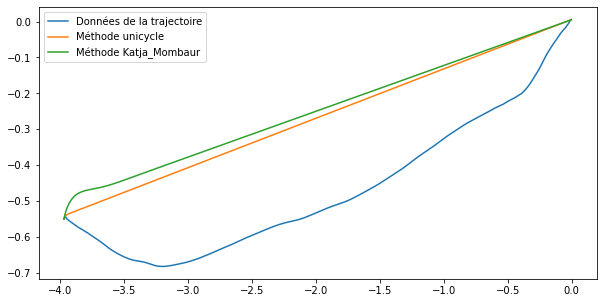

In [119]:
plt.figure(figsize = (10,5))
plt.plot(X1,X2, label = 'Données de la trajectoire' )
plt.plot(X1_S1,X2_S1, label = 'Méthode unicycle')
plt.plot(X_S1,Y_S1, label = 'Méthode Katja_Mombaur')
plt.legend()

# Deuxième trajectoire


In [120]:
T2 = np.loadtxt("human_traj_2.dat")

In [121]:
X1 = T2[0]
X2 = T2[1]
X3 = T2[5]

U1 = T2[2]*cos(T2[4])
U2 = (K(T2[5])-T2[5])/taux


Xi = [X1[0],X2[0],X3[0]]
Xf = [X1[-1],X2[-1],X3[-1]]

x1i = Xi[0]
x2i = Xi[0]
x3i = Xi[0]

x1f = Xf[-1]
x2f = Xf[-1]
x3f = Xf[-1]


X = T2[0]
Y = T2[1]
THETA = T2[5]

V1 = T2[2]
V2 = T2[3]
W  = (K(T2[5])-T2[5])/taux

In [122]:
## Puydupin-Jamin

c1, c2, Lambda = Unicycle_IOC (R_U, U1,U2,X1,X2,X3,Xi,Xf)

Residue_Unicycle_IOC = R_U(U1,U2,X1,X2,X3, Lambda, c1, c2 , x1i,x2i,x3i, x1f,x2f,x3f ) 

X1_S1 ,X2_S1,X3_S1,U1_S1,U2_S1  = Unicycle_DOC (f, Xi , Xf , c1 , c2) 

Residue_Unicycle_DOC = R_U(U1_S1,U2_S1,X1_S1,X2_S1,X3_S1, Lambda, c1, c2 , x1i,x2i,x3i, x1f,x2f,x3f ) 


## Katja_Mombaur

alpha1, alpha2, alpha3, Lambda = Katja_Mombaur_IOC (R_K, V1,V2,W,X,Y,THETA,Xi,Xf)

Residue_Mombaur_IOC  = R_K(V1,W,V2,X,Y,THETA, Lambda, alpha1, alpha2, alpha3, xi,yi,thetai, xf,yf,thetaf  )

X_S1,Y_S1,THETA_S1, V1_S1,V2_S1,W_S1 = Katja_Mombaur_DOC (f,h, Xi, Xf, alpha1, alpha2, alpha3)

Residue_Mombaur_DOC  = R_K(V1_S1,W_S1,V2_S1,X_S1,Y_S1,THETA_S1, Lambda, alpha1, alpha2, alpha3, xi,yi,thetai, xf,yf,thetaf  )

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:        2
Number of nonzeros in inequality constraint Jacobian.:        2
Number of nonzeros in Lagrangian Hessian.............:     6997

Total number of variables............................:     1505
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        2
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.00e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

In [123]:
print("Puydupin-Jamin")
print("le residu après le IOC : ", Residue_Unicycle_IOC)
print("le residu après le DOC : ",Residue_Unicycle_DOC)

print()


print("Katja_Mombaur")
print("le residu après le IOC : ",Residue_Mombaur_IOC)
print("le residu après le DOC : ",Residue_Mombaur_DOC)

Puydupin-Jamin
le residu après le IOC :  7.40766e-05
le residu après le DOC :  0.00554235

Katja_Mombaur
le residu après le IOC :  547.053
le residu après le DOC :  0.184917


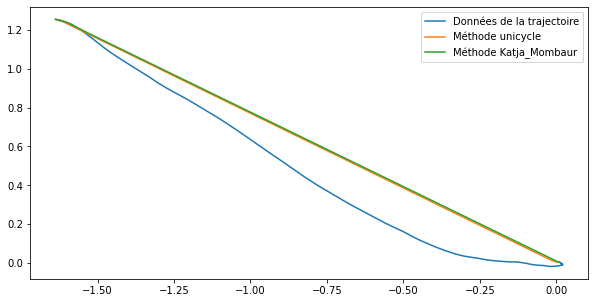

In [124]:
plt.figure(figsize = (10,5))
plt.plot(X1,X2, label = 'Données de la trajectoire' )
plt.plot(X1_S1,X2_S1, label = 'Méthode unicycle')
plt.plot(X_S1,Y_S1, label = 'Méthode Katja_Mombaur')
plt.legend()

# Troisième trajectoire

In [110]:
T3 = np.loadtxt("human_traj_3.dat")

In [111]:
X1 = T3[0]
X2 = T3[1]
X3 = T3[5]

U1 = T3[2]*cos(T3[4])
U2 = (K(T3[5])-T3[5])/taux


Xi = [X1[0],X2[0],X3[0]]
Xf = [X1[-1],X2[-1],X3[-1]]

x1i = Xi[0]
x2i = Xi[0]
x3i = Xi[0]

x1f = Xf[-1]
x2f = Xf[-1]
x3f = Xf[-1]


X = T3[0]
Y = T3[1]
THETA = T3[5]

V1 = T3[2]
V2 = T3[3]
W  = (K(T3[5])-T3[5])/taux

In [112]:
## Puydupin-Jamin

c1, c2, Lambda = Unicycle_IOC (R_U, U1,U2,X1,X2,X3,Xi,Xf)

Residue_Unicycle_IOC = R_U(U1,U2,X1,X2,X3, Lambda, c1, c2 , x1i,x2i,x3i, x1f,x2f,x3f ) 

X1_S1 ,X2_S1,X3_S1,U1_S1,U2_S1  = Unicycle_DOC (f, Xi , Xf , c1 , c2) 

Residue_Unicycle_DOC = R_U(U1_S1,U2_S1,X1_S1,X2_S1,X3_S1, Lambda, c1, c2 , x1i,x2i,x3i, x1f,x2f,x3f ) 


## Katja_Mombaur

alpha1, alpha2, alpha3, Lambda = Katja_Mombaur_IOC (R_K, V1,V2,W,X,Y,THETA,Xi,Xf)

Residue_Mombaur_IOC  = R_K(V1,W,V2,X,Y,THETA, Lambda, alpha1, alpha2, alpha3, xi,yi,thetai, xf,yf,thetaf  )

X_S1,Y_S1,THETA_S1, V1_S1,V2_S1,W_S1 = Katja_Mombaur_DOC (f,h, Xi, Xf, alpha1, alpha2, alpha3)

Residue_Mombaur_DOC  = R_K(V1_S1,W_S1,V2_S1,X_S1,Y_S1,THETA_S1, Lambda, alpha1, alpha2, alpha3, xi,yi,thetai, xf,yf,thetaf  )

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:        2
Number of nonzeros in inequality constraint Jacobian.:        2
Number of nonzeros in Lagrangian Hessian.............:     6997

Total number of variables............................:     1505
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        2
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.00e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

In [113]:
print("Puydupin-Jamin")
print("le residu après le IOC : ", Residue_Unicycle_IOC)
print("le residu après le DOC : ",Residue_Unicycle_DOC)

print()


print("Katja_Mombaur")
print("le residu après le IOC : ",Residue_Mombaur_IOC)
print("le residu après le DOC : ",Residue_Mombaur_DOC)

Puydupin-Jamin
le residu après le IOC :  8.19653e-05
le residu après le DOC :  0.0458586

Katja_Mombaur
le residu après le IOC :  6686.05
le residu après le DOC :  0.804528


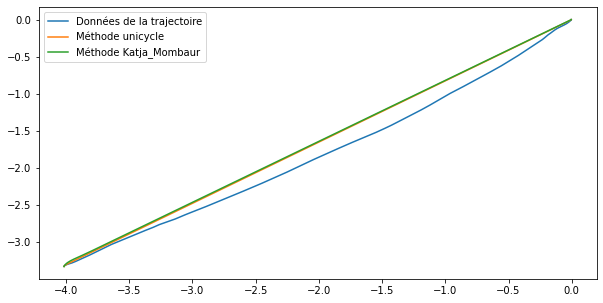

In [114]:
plt.figure(figsize = (10,5))
plt.plot(X1,X2, label = 'Données de la trajectoire' )
plt.plot(X1_S1,X2_S1, label = 'Méthode unicycle')
plt.plot(X_S1,Y_S1, label = 'Méthode Katja_Mombaur')
plt.legend()